 Data Loaded Successfully!

      Dates  Prices
0  10/31/20    10.1
1  11/30/20    10.3
2  12/31/20    11.0
3   1/31/21    10.9
4   2/28/21    10.9

 Starting Storage Contract Pricing...

 Injected 1,000,000 MMBtu on 2024-06-30 at $11.5/MMBtu
 Injected 1,000,000 MMBtu on 2024-07-31 at $11.6/MMBtu
 No price data for 2024-12-31, skipping...
 No price data for 2025-01-31, skipping...

 Storage cost for 2 months: $200,000.00

--------------------------------------
 Estimated Contract Value: $-23,420,000.00
--------------------------------------


/tmp/ipython-input-3145754607.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


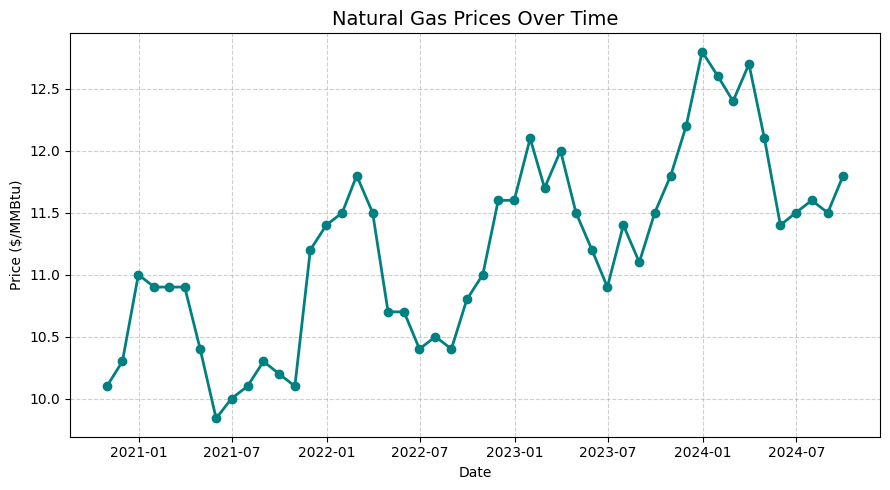

In [7]:

#  J.P. Morgan Virtual Internship – Task 2
#  Title: Price a Commodity Storage Contract
#  Author: Nagesh Awachar


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


file_path = "/content/Nat_Gas (1).csv"
df = pd.read_csv(file_path)

print(" Data Loaded Successfully!\n")
print(df.head())

# --- Clean & Prepare Data ---
# Rename columns properly
df.columns = [col.strip().capitalize() for col in df.columns]
df.rename(columns={'Dates': 'Date', 'Prices': 'Price'}, inplace=True)

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with invalid dates (if any)
df = df.dropna(subset=['Date'])

# Create dictionary: date → price
prices = dict(zip(df['Date'].dt.strftime('%Y-%m-%d'), df['Price']))

# --- Define Pricing Function ---
def price_storage_contract(injection_dates, withdrawal_dates, prices,
                           injection_rate, withdrawal_rate,
                           max_storage, storage_cost_per_month,
                           injection_withdrawal_fee, transport_fee_per_event):
    """
    Function to calculate the total value of a natural gas storage contract.
    """

    total_volume = 0
    total_value = 0

    print("\n Starting Storage Contract Pricing...\n")

    # Injection Phase (Buying Gas)
    for date in injection_dates:
        buy_price = prices.get(date)
        if buy_price is None:
            print(f" No price data for {date}, skipping...")
            continue

        volume = min(injection_rate, max_storage - total_volume)
        total_value -= buy_price * volume
        total_volume += volume
        total_value -= (injection_withdrawal_fee + transport_fee_per_event)
        print(f" Injected {volume:,} MMBtu on {date} at ${buy_price}/MMBtu")

    # Withdrawal Phase (Selling Gas)
    for date in withdrawal_dates:
        sell_price = prices.get(date)
        if sell_price is None:
            print(f" No price data for {date}, skipping...")
            continue

        volume = min(withdrawal_rate, total_volume)
        total_value += sell_price * volume
        total_volume -= volume
        total_value -= (injection_withdrawal_fee + transport_fee_per_event)
        print(f" Withdrew {volume:,} MMBtu on {date} at ${sell_price}/MMBtu")

    # Storage Cost Calculation
    months = len(set(injection_dates + withdrawal_dates)) // 2
    total_value -= months * storage_cost_per_month
    print(f"\n Storage cost for {months} months: ${months * storage_cost_per_month:,.2f}")

    return total_value


# --- Example Test Input ---
injection_dates = ['2024-06-30', '2024-07-31']
withdrawal_dates = ['2024-12-31', '2025-01-31']
injection_rate = 1_000_000
withdrawal_rate = 1_000_000
max_storage = 2_000_000
storage_cost_per_month = 100_000
injection_withdrawal_fee = 10_000
transport_fee_per_event = 50_000

# --- Run the Pricing Model ---
contract_value = price_storage_contract(
    injection_dates, withdrawal_dates, prices,
    injection_rate, withdrawal_rate, max_storage,
    storage_cost_per_month, injection_withdrawal_fee, transport_fee_per_event
)

print("\n--------------------------------------")
print(f" Estimated Contract Value: ${contract_value:,.2f}")
print("--------------------------------------")

# --- Visualize the Price Trend ---
plt.figure(figsize=(9,5))
plt.plot(df['Date'], df['Price'], marker='o', linewidth=2, color='teal')
plt.title("Natural Gas Prices Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price ($/MMBtu)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
